# Image Classification
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
# floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
# if isfile(floyd_cifar10_location):
#     tar_gz_path = floyd_cifar10_location
# else:
tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


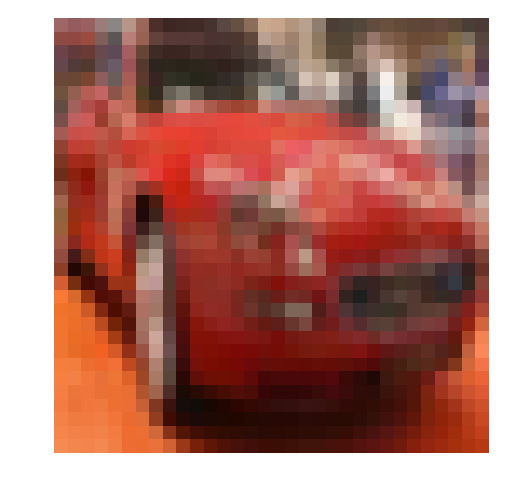

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    return (x - x.min()) / (x.max() - x.min())

tests.test_normalize(normalize)

Tests Passed


### One-hot encode
Just like the previous code cell, you'll be implementing a function for preprocessing.  This time, you'll implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.  Make sure to save the map of encodings outside the function.

Hint: Don't reinvent the wheel.

In [4]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    return np.eye(10)[x]

tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but you don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [5]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [6]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, you'll build each layer into a function.  Most of the code you've seen has been outside of functions. To test your code more thoroughly, we require that you put each layer in a function.  This allows us to give you better feedback and test for simple mistakes using our unittests before you submit your project.

>**Note:** If you're finding it hard to dedicate enough time for this course each week, we've provided a small shortcut to this part of the project. In the next couple of problems, you'll have the option to use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages to build each layer, except the layers you build in the "Convolutional and Max Pooling Layer" section.  TF Layers is similar to Keras's and TFLearn's abstraction to layers, so it's easy to pickup.

>However, if you would like to get the most out of this course, try to solve all the problems _without_ using anything from the TF Layers packages. You **can** still use classes from other packages that happen to have the same name as ones you find in TF Layers! For example, instead of using the TF Layers version of the `conv2d` class, [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d), you would want to use the TF Neural Network version of `conv2d`, [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 

Let's begin!

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load your saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [7]:
import tensorflow as tf

In [8]:
def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, shape=(None,*image_shape), name = 'x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, shape=(None, n_classes), name = 'y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, shape=(None), name = 'keep_prob')

# tf.reset_default_graph()
# tests.test_nn_image_inputs(neural_net_image_input)
# tests.test_nn_label_inputs(neural_net_label_input)
# tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.

**Note:** You **can't** use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for **this** layer, but you can still use TensorFlow's [Neural Network](https://www.tensorflow.org/api_docs/python/tf/nn) package. You may still use the shortcut option for all the **other** layers.

In [9]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, padding = 'SAME'):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    with tf.name_scope('Conv2d_maxpool'):
        W = tf.Variable(tf.truncated_normal(shape = (*conv_ksize, x_tensor.get_shape().as_list()[3],conv_num_outputs), 
                                            mean=0.0, 
                                            stddev=0.1,
                                            dtype=tf.float32, 
                                            name = 'conv_W'))
        b = tf.Variable(tf.zeros(conv_num_outputs, 
                                 dtype=tf.float32,
                                 name = 'conv_b'))
        conv = tf.nn.conv2d(x_tensor, W, [1, *conv_strides ,1], padding, name = 'conv2d')
        conv += b
        conv = tf.nn.relu(conv)
        tf.summary.histogram("conv_weights", W)
        tf.summary.histogram("conv_bias", b)
        max_pooled_conv = tf.nn.max_pool(conv, [1, *pool_ksize ,1], [1, *pool_strides ,1], padding, name='max_pool')
        return max_pooled_conv

# tests.test_con_pool(conv2d_maxpool)

### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [10]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    with tf.name_scope('Flatten'):
        return tf.reshape(x_tensor, shape = (-1 ,np.prod(x_tensor.get_shape().as_list()[1:])), name = 'flatten')

# tests.test_flatten(flatten)

### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [11]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    with tf.name_scope('FC'):
        W = tf.Variable(tf.truncated_normal(shape = (x_tensor.get_shape().as_list()[1], num_outputs), 
                                            mean=0.0,
                                            stddev=0.1,
                                            dtype=tf.float32, 
                                            name = 'FC_W'))
        b = tf.Variable(tf.zeros(num_outputs, 
                                 dtype=tf.float32,
                                 name = 'FC_b'))
        fc = tf.matmul(x_tensor, W) + b
        fc_act = tf.nn.relu(fc)
        tf.summary.histogram("FC_weights", W)
        tf.summary.histogram("FC_bias", b)
        return fc_act

# tests.test_fully_conn(fully_conn)

### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

**Note:** Activation, softmax, or cross entropy should **not** be applied to this.

In [12]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    with tf.name_scope('Output'):
        W = tf.Variable(tf.truncated_normal(shape = (x_tensor.get_shape().as_list()[1], num_outputs), 
                                            mean=0.0,
                                            stddev=0.1,
                                            dtype=tf.float32, 
                                            name = 'Out_W'))
        b = tf.Variable(tf.zeros(num_outputs, 
                                 dtype=tf.float32,
                                 name = 'Out_b'))
        fc = tf.matmul(x_tensor, W) + b
        tf.summary.histogram("Output_weights", W)
        tf.summary.histogram("Output_bias", b)
        return fc

# tests.test_output(output)

### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [13]:
def conv_net_1(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """

    l1 = conv2d_maxpool(x, 
                        conv_num_outputs = 16, 
                        conv_ksize = (1,1), 
                        conv_strides = (1,1), 
                        pool_ksize  = (2,2), 
                        pool_strides = (2,2))
    l1 = tf.contrib.layers.batch_norm(l1)
    
    l2 = conv2d_maxpool(l1, 
                        conv_num_outputs = 32, 
                        conv_ksize = (3,3), 
                        conv_strides = (1,1), 
                        pool_ksize  = (2,2), 
                        pool_strides = (2,2))
    l2 = tf.contrib.layers.batch_norm(l2)
    
    l3 = conv2d_maxpool(l2, 
                    conv_num_outputs = 64, 
                    conv_ksize = (3,3), 
                    conv_strides = (1,1), 
                    pool_ksize  = (2,2), 
                    pool_strides = (2,2))
    l3 = tf.contrib.layers.batch_norm(l3)
    
    l4 = flatten(l3)
    l4 = tf.nn.dropout(l4, keep_prob)
    
    l5 = fully_conn(l4, 512)
    l5 = tf.nn.dropout(l5, keep_prob)
    
    l6 = fully_conn(l5, 256)
    
    return output(l6, 10)

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net_1(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
with tf.name_scope('Xent'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    tf.summary.scalar('softmax_cross_entropy_with_logits', cost)
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
with tf.name_scope('accuracy'):
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    tf.summary.scalar('accuracy', accuracy)

# tests.test_conv_net(conv_net)

## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [14]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    with tf.name_scope('adam'):
        return session.run([optimizer], feed_dict = {x: feature_batch, y:label_batch, keep_prob: keep_probability})

# tests.test_train_nn(train_neural_network)

### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [15]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    with tf.name_scope('stats'):
        loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
        t_acc = session.run(accuracy, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
        v_acc = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.})
        print(f'Loss: {loss:.5f} Training accuracy: {t_acc:.5f} Validation accuracy: {v_acc:.5f}')

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [ ]:
epochs = 20
batch_size = 128
keep_probability = 0.6

print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [16]:
epochs = 256
batch_size = 64
keep_probability = 0.4

save_model_path = './image_classification_1'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    merged_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter("summary/cifar10/_1")
    writer.add_graph(sess.graph)
    c = 0
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer , keep_probability, batch_features, batch_labels)
            c+=1
            s = sess.run(merged_summary, feed_dict = {x: batch_features, y: batch_labels, keep_prob: keep_probability})
            writer.add_summary(s, c)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss: 1.96911 Training accuracy: 0.30000 Validation accuracy: 0.30960
Epoch  1, CIFAR-10 Batch 2:  Loss: 1.87559 Training accuracy: 0.27500 Validation accuracy: 0.32220
Epoch  1, CIFAR-10 Batch 3:  Loss: 1.80088 Training accuracy: 0.42500 Validation accuracy: 0.34160
Epoch  1, CIFAR-10 Batch 4:  Loss: 1.80499 Training accuracy: 0.32500 Validation accuracy: 0.37080
Epoch  1, CIFAR-10 Batch 5:  Loss: 1.75126 Training accuracy: 0.40000 Validation accuracy: 0.37360
Epoch  2, CIFAR-10 Batch 1:  Loss: 1.84196 Training accuracy: 0.40000 Validation accuracy: 0.40460
Epoch  2, CIFAR-10 Batch 2:  Loss: 1.75397 Training accuracy: 0.35000 Validation accuracy: 0.42140
Epoch  2, CIFAR-10 Batch 3:  Loss: 1.47213 Training accuracy: 0.42500 Validation accuracy: 0.42420
Epoch  2, CIFAR-10 Batch 4:  Loss: 1.56159 Training accuracy: 0.47500 Validation accuracy: 0.44060
Epoch  2, CIFAR-10 Batch 5:  Loss: 1.56908 Training accuracy: 0.45000 Validation accuracy: 0.4542

Epoch 17, CIFAR-10 Batch 4:  Loss: 0.75636 Training accuracy: 0.75000 Validation accuracy: 0.67800
Epoch 17, CIFAR-10 Batch 5:  Loss: 0.76820 Training accuracy: 0.80000 Validation accuracy: 0.69200
Epoch 18, CIFAR-10 Batch 1:  Loss: 0.91905 Training accuracy: 0.67500 Validation accuracy: 0.67820
Epoch 18, CIFAR-10 Batch 2:  Loss: 0.88081 Training accuracy: 0.70000 Validation accuracy: 0.68500
Epoch 18, CIFAR-10 Batch 3:  Loss: 0.62089 Training accuracy: 0.80000 Validation accuracy: 0.68380
Epoch 18, CIFAR-10 Batch 4:  Loss: 0.76393 Training accuracy: 0.72500 Validation accuracy: 0.68140
Epoch 18, CIFAR-10 Batch 5:  Loss: 0.79279 Training accuracy: 0.75000 Validation accuracy: 0.69640
Epoch 19, CIFAR-10 Batch 1:  Loss: 0.91021 Training accuracy: 0.65000 Validation accuracy: 0.68940
Epoch 19, CIFAR-10 Batch 2:  Loss: 0.87905 Training accuracy: 0.70000 Validation accuracy: 0.68900
Epoch 19, CIFAR-10 Batch 3:  Loss: 0.57100 Training accuracy: 0.85000 Validation accuracy: 0.68880
Epoch 19, 

Epoch 34, CIFAR-10 Batch 2:  Loss: 0.75390 Training accuracy: 0.72500 Validation accuracy: 0.71720
Epoch 34, CIFAR-10 Batch 3:  Loss: 0.42551 Training accuracy: 0.87500 Validation accuracy: 0.71580
Epoch 34, CIFAR-10 Batch 4:  Loss: 0.54341 Training accuracy: 0.87500 Validation accuracy: 0.71880
Epoch 34, CIFAR-10 Batch 5:  Loss: 0.56798 Training accuracy: 0.85000 Validation accuracy: 0.72740
Epoch 35, CIFAR-10 Batch 1:  Loss: 0.67464 Training accuracy: 0.77500 Validation accuracy: 0.71840
Epoch 35, CIFAR-10 Batch 2:  Loss: 0.66245 Training accuracy: 0.82500 Validation accuracy: 0.72520
Epoch 35, CIFAR-10 Batch 3:  Loss: 0.43755 Training accuracy: 0.87500 Validation accuracy: 0.72320
Epoch 35, CIFAR-10 Batch 4:  Loss: 0.59709 Training accuracy: 0.80000 Validation accuracy: 0.71440
Epoch 35, CIFAR-10 Batch 5:  Loss: 0.52027 Training accuracy: 0.87500 Validation accuracy: 0.72500
Epoch 36, CIFAR-10 Batch 1:  Loss: 0.68729 Training accuracy: 0.75000 Validation accuracy: 0.73100
Epoch 36, 

Epoch 50, CIFAR-10 Batch 5:  Loss: 0.45443 Training accuracy: 0.90000 Validation accuracy: 0.74220
Epoch 51, CIFAR-10 Batch 1:  Loss: 0.59067 Training accuracy: 0.75000 Validation accuracy: 0.73760
Epoch 51, CIFAR-10 Batch 2:  Loss: 0.56279 Training accuracy: 0.87500 Validation accuracy: 0.73660
Epoch 51, CIFAR-10 Batch 3:  Loss: 0.39247 Training accuracy: 0.87500 Validation accuracy: 0.73540
Epoch 51, CIFAR-10 Batch 4:  Loss: 0.47578 Training accuracy: 0.87500 Validation accuracy: 0.73460
Epoch 51, CIFAR-10 Batch 5:  Loss: 0.46387 Training accuracy: 0.87500 Validation accuracy: 0.74740
Epoch 52, CIFAR-10 Batch 1:  Loss: 0.57276 Training accuracy: 0.75000 Validation accuracy: 0.73780
Epoch 52, CIFAR-10 Batch 2:  Loss: 0.57840 Training accuracy: 0.80000 Validation accuracy: 0.74480
Epoch 52, CIFAR-10 Batch 3:  Loss: 0.31288 Training accuracy: 0.92500 Validation accuracy: 0.74420
Epoch 52, CIFAR-10 Batch 4:  Loss: 0.47139 Training accuracy: 0.90000 Validation accuracy: 0.74900
Epoch 52, 

Epoch 67, CIFAR-10 Batch 3:  Loss: 0.28378 Training accuracy: 0.95000 Validation accuracy: 0.74240
Epoch 67, CIFAR-10 Batch 4:  Loss: 0.43643 Training accuracy: 0.90000 Validation accuracy: 0.75040
Epoch 67, CIFAR-10 Batch 5:  Loss: 0.35310 Training accuracy: 0.95000 Validation accuracy: 0.74740
Epoch 68, CIFAR-10 Batch 1:  Loss: 0.55634 Training accuracy: 0.77500 Validation accuracy: 0.74760
Epoch 68, CIFAR-10 Batch 2:  Loss: 0.44198 Training accuracy: 0.92500 Validation accuracy: 0.74880
Epoch 68, CIFAR-10 Batch 3:  Loss: 0.31114 Training accuracy: 0.92500 Validation accuracy: 0.75060
Epoch 68, CIFAR-10 Batch 4:  Loss: 0.42562 Training accuracy: 0.90000 Validation accuracy: 0.75200
Epoch 68, CIFAR-10 Batch 5:  Loss: 0.36213 Training accuracy: 0.92500 Validation accuracy: 0.75260
Epoch 69, CIFAR-10 Batch 1:  Loss: 0.51541 Training accuracy: 0.77500 Validation accuracy: 0.74540
Epoch 69, CIFAR-10 Batch 2:  Loss: 0.45090 Training accuracy: 0.82500 Validation accuracy: 0.74540
Epoch 69, 

Epoch 84, CIFAR-10 Batch 1:  Loss: 0.48490 Training accuracy: 0.87500 Validation accuracy: 0.75380
Epoch 84, CIFAR-10 Batch 2:  Loss: 0.43653 Training accuracy: 0.90000 Validation accuracy: 0.74820
Epoch 84, CIFAR-10 Batch 3:  Loss: 0.29447 Training accuracy: 0.90000 Validation accuracy: 0.75380
Epoch 84, CIFAR-10 Batch 4:  Loss: 0.40008 Training accuracy: 0.87500 Validation accuracy: 0.75960
Epoch 84, CIFAR-10 Batch 5:  Loss: 0.32323 Training accuracy: 0.95000 Validation accuracy: 0.75660
Epoch 85, CIFAR-10 Batch 1:  Loss: 0.52482 Training accuracy: 0.80000 Validation accuracy: 0.74700
Epoch 85, CIFAR-10 Batch 2:  Loss: 0.46494 Training accuracy: 0.90000 Validation accuracy: 0.75220
Epoch 85, CIFAR-10 Batch 3:  Loss: 0.25371 Training accuracy: 0.92500 Validation accuracy: 0.75640
Epoch 85, CIFAR-10 Batch 4:  Loss: 0.38798 Training accuracy: 0.90000 Validation accuracy: 0.75660
Epoch 85, CIFAR-10 Batch 5:  Loss: 0.36504 Training accuracy: 0.95000 Validation accuracy: 0.75680
Epoch 86, 

Epoch 100, CIFAR-10 Batch 4:  Loss: 0.36780 Training accuracy: 0.90000 Validation accuracy: 0.76660
Epoch 100, CIFAR-10 Batch 5:  Loss: 0.31088 Training accuracy: 0.90000 Validation accuracy: 0.75820
Epoch 101, CIFAR-10 Batch 1:  Loss: 0.45105 Training accuracy: 0.82500 Validation accuracy: 0.76180
Epoch 101, CIFAR-10 Batch 2:  Loss: 0.35827 Training accuracy: 0.90000 Validation accuracy: 0.75600
Epoch 101, CIFAR-10 Batch 3:  Loss: 0.25914 Training accuracy: 0.92500 Validation accuracy: 0.76200
Epoch 101, CIFAR-10 Batch 4:  Loss: 0.39023 Training accuracy: 0.92500 Validation accuracy: 0.75340
Epoch 101, CIFAR-10 Batch 5:  Loss: 0.32343 Training accuracy: 0.90000 Validation accuracy: 0.75860
Epoch 102, CIFAR-10 Batch 1:  Loss: 0.43154 Training accuracy: 0.85000 Validation accuracy: 0.76160
Epoch 102, CIFAR-10 Batch 2:  Loss: 0.41052 Training accuracy: 0.85000 Validation accuracy: 0.76260
Epoch 102, CIFAR-10 Batch 3:  Loss: 0.25174 Training accuracy: 0.95000 Validation accuracy: 0.76620


Epoch 117, CIFAR-10 Batch 1:  Loss: 0.45649 Training accuracy: 0.80000 Validation accuracy: 0.75820
Epoch 117, CIFAR-10 Batch 2:  Loss: 0.37608 Training accuracy: 0.90000 Validation accuracy: 0.76120
Epoch 117, CIFAR-10 Batch 3:  Loss: 0.21358 Training accuracy: 0.97500 Validation accuracy: 0.76480
Epoch 117, CIFAR-10 Batch 4:  Loss: 0.32226 Training accuracy: 0.90000 Validation accuracy: 0.76140
Epoch 117, CIFAR-10 Batch 5:  Loss: 0.31711 Training accuracy: 0.95000 Validation accuracy: 0.75820
Epoch 118, CIFAR-10 Batch 1:  Loss: 0.44730 Training accuracy: 0.82500 Validation accuracy: 0.76080
Epoch 118, CIFAR-10 Batch 2:  Loss: 0.36038 Training accuracy: 0.92500 Validation accuracy: 0.76300
Epoch 118, CIFAR-10 Batch 3:  Loss: 0.24283 Training accuracy: 0.92500 Validation accuracy: 0.76080
Epoch 118, CIFAR-10 Batch 4:  Loss: 0.34081 Training accuracy: 0.92500 Validation accuracy: 0.76360
Epoch 118, CIFAR-10 Batch 5:  Loss: 0.35124 Training accuracy: 0.95000 Validation accuracy: 0.76720


Epoch 133, CIFAR-10 Batch 3:  Loss: 0.20426 Training accuracy: 0.97500 Validation accuracy: 0.76300
Epoch 133, CIFAR-10 Batch 4:  Loss: 0.32395 Training accuracy: 0.92500 Validation accuracy: 0.76520
Epoch 133, CIFAR-10 Batch 5:  Loss: 0.31375 Training accuracy: 0.95000 Validation accuracy: 0.76460
Epoch 134, CIFAR-10 Batch 1:  Loss: 0.47347 Training accuracy: 0.87500 Validation accuracy: 0.76580
Epoch 134, CIFAR-10 Batch 2:  Loss: 0.34160 Training accuracy: 0.92500 Validation accuracy: 0.75980
Epoch 134, CIFAR-10 Batch 3:  Loss: 0.21312 Training accuracy: 1.00000 Validation accuracy: 0.76300
Epoch 134, CIFAR-10 Batch 4:  Loss: 0.33084 Training accuracy: 0.92500 Validation accuracy: 0.76440
Epoch 134, CIFAR-10 Batch 5:  Loss: 0.32056 Training accuracy: 0.92500 Validation accuracy: 0.76440
Epoch 135, CIFAR-10 Batch 1:  Loss: 0.41348 Training accuracy: 0.85000 Validation accuracy: 0.76180
Epoch 135, CIFAR-10 Batch 2:  Loss: 0.32644 Training accuracy: 0.92500 Validation accuracy: 0.75600


Epoch 149, CIFAR-10 Batch 5:  Loss: 0.29432 Training accuracy: 0.95000 Validation accuracy: 0.76580
Epoch 150, CIFAR-10 Batch 1:  Loss: 0.38466 Training accuracy: 0.90000 Validation accuracy: 0.75860
Epoch 150, CIFAR-10 Batch 2:  Loss: 0.33607 Training accuracy: 0.87500 Validation accuracy: 0.76140
Epoch 150, CIFAR-10 Batch 3:  Loss: 0.19852 Training accuracy: 1.00000 Validation accuracy: 0.76920
Epoch 150, CIFAR-10 Batch 4:  Loss: 0.31438 Training accuracy: 0.95000 Validation accuracy: 0.75760
Epoch 150, CIFAR-10 Batch 5:  Loss: 0.29055 Training accuracy: 0.95000 Validation accuracy: 0.76320
Epoch 151, CIFAR-10 Batch 1:  Loss: 0.36572 Training accuracy: 0.95000 Validation accuracy: 0.76620
Epoch 151, CIFAR-10 Batch 2:  Loss: 0.32914 Training accuracy: 0.95000 Validation accuracy: 0.76600
Epoch 151, CIFAR-10 Batch 3:  Loss: 0.21719 Training accuracy: 1.00000 Validation accuracy: 0.76900
Epoch 151, CIFAR-10 Batch 4:  Loss: 0.31035 Training accuracy: 0.95000 Validation accuracy: 0.76620


Epoch 166, CIFAR-10 Batch 2:  Loss: 0.32130 Training accuracy: 0.92500 Validation accuracy: 0.76820
Epoch 166, CIFAR-10 Batch 3:  Loss: 0.24758 Training accuracy: 0.97500 Validation accuracy: 0.76920
Epoch 166, CIFAR-10 Batch 4:  Loss: 0.33677 Training accuracy: 0.95000 Validation accuracy: 0.76420
Epoch 166, CIFAR-10 Batch 5:  Loss: 0.26017 Training accuracy: 1.00000 Validation accuracy: 0.76640
Epoch 167, CIFAR-10 Batch 1:  Loss: 0.38196 Training accuracy: 0.82500 Validation accuracy: 0.77140
Epoch 167, CIFAR-10 Batch 2:  Loss: 0.33428 Training accuracy: 0.95000 Validation accuracy: 0.77400
Epoch 167, CIFAR-10 Batch 3:  Loss: 0.18962 Training accuracy: 0.97500 Validation accuracy: 0.76860
Epoch 167, CIFAR-10 Batch 4:  Loss: 0.30705 Training accuracy: 0.95000 Validation accuracy: 0.77200
Epoch 167, CIFAR-10 Batch 5:  Loss: 0.22114 Training accuracy: 1.00000 Validation accuracy: 0.77300
Epoch 168, CIFAR-10 Batch 1:  Loss: 0.39388 Training accuracy: 0.87500 Validation accuracy: 0.76760


Epoch 182, CIFAR-10 Batch 4:  Loss: 0.30768 Training accuracy: 0.90000 Validation accuracy: 0.77140
Epoch 182, CIFAR-10 Batch 5:  Loss: 0.22525 Training accuracy: 0.97500 Validation accuracy: 0.76800
Epoch 183, CIFAR-10 Batch 1:  Loss: 0.32594 Training accuracy: 0.90000 Validation accuracy: 0.76620
Epoch 183, CIFAR-10 Batch 2:  Loss: 0.31617 Training accuracy: 0.95000 Validation accuracy: 0.77180
Epoch 183, CIFAR-10 Batch 3:  Loss: 0.19550 Training accuracy: 0.92500 Validation accuracy: 0.76040
Epoch 183, CIFAR-10 Batch 4:  Loss: 0.32871 Training accuracy: 0.92500 Validation accuracy: 0.76800
Epoch 183, CIFAR-10 Batch 5:  Loss: 0.25164 Training accuracy: 0.95000 Validation accuracy: 0.76960
Epoch 184, CIFAR-10 Batch 1:  Loss: 0.33769 Training accuracy: 0.92500 Validation accuracy: 0.76860
Epoch 184, CIFAR-10 Batch 2:  Loss: 0.25758 Training accuracy: 0.97500 Validation accuracy: 0.76940
Epoch 184, CIFAR-10 Batch 3:  Loss: 0.18839 Training accuracy: 0.97500 Validation accuracy: 0.77180


Epoch 199, CIFAR-10 Batch 1:  Loss: 0.36079 Training accuracy: 0.85000 Validation accuracy: 0.77320
Epoch 199, CIFAR-10 Batch 2:  Loss: 0.27484 Training accuracy: 0.97500 Validation accuracy: 0.76520
Epoch 199, CIFAR-10 Batch 3:  Loss: 0.19016 Training accuracy: 0.97500 Validation accuracy: 0.76980
Epoch 199, CIFAR-10 Batch 4:  Loss: 0.32726 Training accuracy: 0.95000 Validation accuracy: 0.76580
Epoch 199, CIFAR-10 Batch 5:  Loss: 0.22347 Training accuracy: 0.97500 Validation accuracy: 0.76920
Epoch 200, CIFAR-10 Batch 1:  Loss: 0.39737 Training accuracy: 0.87500 Validation accuracy: 0.76820
Epoch 200, CIFAR-10 Batch 2:  Loss: 0.25354 Training accuracy: 0.95000 Validation accuracy: 0.77400
Epoch 200, CIFAR-10 Batch 3:  Loss: 0.18159 Training accuracy: 0.95000 Validation accuracy: 0.76300
Epoch 200, CIFAR-10 Batch 4:  Loss: 0.28092 Training accuracy: 0.97500 Validation accuracy: 0.76840
Epoch 200, CIFAR-10 Batch 5:  Loss: 0.20613 Training accuracy: 0.97500 Validation accuracy: 0.77100


Epoch 215, CIFAR-10 Batch 3:  Loss: 0.18621 Training accuracy: 0.97500 Validation accuracy: 0.76420
Epoch 215, CIFAR-10 Batch 4:  Loss: 0.28712 Training accuracy: 0.97500 Validation accuracy: 0.77680
Epoch 215, CIFAR-10 Batch 5:  Loss: 0.24353 Training accuracy: 0.97500 Validation accuracy: 0.77280
Epoch 216, CIFAR-10 Batch 1:  Loss: 0.32402 Training accuracy: 0.95000 Validation accuracy: 0.77360
Epoch 216, CIFAR-10 Batch 2:  Loss: 0.28189 Training accuracy: 0.90000 Validation accuracy: 0.76740
Epoch 216, CIFAR-10 Batch 3:  Loss: 0.18474 Training accuracy: 1.00000 Validation accuracy: 0.76980
Epoch 216, CIFAR-10 Batch 4:  Loss: 0.29290 Training accuracy: 0.97500 Validation accuracy: 0.77480
Epoch 216, CIFAR-10 Batch 5:  Loss: 0.20373 Training accuracy: 1.00000 Validation accuracy: 0.76980
Epoch 217, CIFAR-10 Batch 1:  Loss: 0.33296 Training accuracy: 0.90000 Validation accuracy: 0.77280
Epoch 217, CIFAR-10 Batch 2:  Loss: 0.26870 Training accuracy: 0.92500 Validation accuracy: 0.76680


Epoch 231, CIFAR-10 Batch 5:  Loss: 0.20842 Training accuracy: 0.97500 Validation accuracy: 0.77280
Epoch 232, CIFAR-10 Batch 1:  Loss: 0.37074 Training accuracy: 0.90000 Validation accuracy: 0.76760
Epoch 232, CIFAR-10 Batch 2:  Loss: 0.28500 Training accuracy: 0.92500 Validation accuracy: 0.76680
Epoch 232, CIFAR-10 Batch 3:  Loss: 0.19038 Training accuracy: 0.95000 Validation accuracy: 0.76540
Epoch 232, CIFAR-10 Batch 4:  Loss: 0.27148 Training accuracy: 0.95000 Validation accuracy: 0.76760
Epoch 232, CIFAR-10 Batch 5:  Loss: 0.18183 Training accuracy: 0.97500 Validation accuracy: 0.76960
Epoch 233, CIFAR-10 Batch 1:  Loss: 0.33075 Training accuracy: 0.85000 Validation accuracy: 0.76020
Epoch 233, CIFAR-10 Batch 2:  Loss: 0.27104 Training accuracy: 0.92500 Validation accuracy: 0.76720
Epoch 233, CIFAR-10 Batch 3:  Loss: 0.19120 Training accuracy: 1.00000 Validation accuracy: 0.76780
Epoch 233, CIFAR-10 Batch 4:  Loss: 0.28419 Training accuracy: 0.95000 Validation accuracy: 0.75840


Epoch 248, CIFAR-10 Batch 2:  Loss: 0.26963 Training accuracy: 0.90000 Validation accuracy: 0.76720
Epoch 248, CIFAR-10 Batch 3:  Loss: 0.17155 Training accuracy: 0.95000 Validation accuracy: 0.77500
Epoch 248, CIFAR-10 Batch 4:  Loss: 0.27915 Training accuracy: 0.95000 Validation accuracy: 0.76840
Epoch 248, CIFAR-10 Batch 5:  Loss: 0.19633 Training accuracy: 1.00000 Validation accuracy: 0.77240
Epoch 249, CIFAR-10 Batch 1:  Loss: 0.30197 Training accuracy: 0.92500 Validation accuracy: 0.77060
Epoch 249, CIFAR-10 Batch 2:  Loss: 0.24217 Training accuracy: 0.95000 Validation accuracy: 0.76860
Epoch 249, CIFAR-10 Batch 3:  Loss: 0.16264 Training accuracy: 0.97500 Validation accuracy: 0.76380
Epoch 249, CIFAR-10 Batch 4:  Loss: 0.26154 Training accuracy: 0.97500 Validation accuracy: 0.77300
Epoch 249, CIFAR-10 Batch 5:  Loss: 0.23683 Training accuracy: 0.95000 Validation accuracy: 0.77120
Epoch 250, CIFAR-10 Batch 1:  Loss: 0.32158 Training accuracy: 0.90000 Validation accuracy: 0.76820


# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

INFO:tensorflow:Restoring parameters from ./image_classification_1
Testing Accuracy: 0.7575636942675159



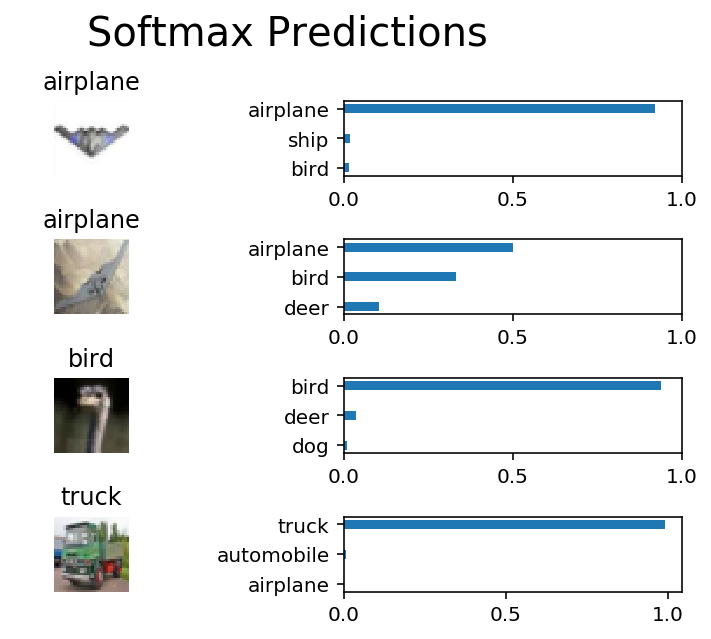

In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification_1'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy/accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-80% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 80%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because we haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "dlnd_image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.

# Tensorboard records

In [30]:
#Credit for iPython notebook Tensorboard snippet
#https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter/38192374#38192374

In [31]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [32]:
show_graph(tf.get_default_graph().as_graph_def())

/home/dl/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: PyUnicode_AsEncodedObject() is deprecated; use PyUnicode_AsEncodedString() to encode from str to bytes or PyCodec_Encode() for generic encoding
  # Remove the CWD from sys.path while we load stuff.


# Xentropy & Accuracy

![Xent&Acc](misc/accuracy.png)

# Weight & bias distributions

![W&b](misc/weights.png)

# Histograms

![Histograms](misc/histograms.png)